In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
# %matplotlib notebook

In [16]:
Image('wheel_encoders.png')

In a differential-drive model, we discussed the relation between wheel velocities and robot's rotational and translational velocity, i.e, $v, \omega$. 

If we need to know curent $v, \omega$ how to measure wheel velocities? We use wheel encoders

Encoder resolution = $N$

Every $\Delta T$ ms,
+ Encoder reports # ticks wheel moved = $n$
+ Angle moved = $2\pi \frac{n}{N}$

Usage
+ Smallest movement that can be measured is $\frac{2\pi}{N}$
+ Largest speed that can be measured is $\frac{2\pi}{\Delta T}$

Pros:
+ Fairly accurate estimates of linear/ angular velocity
+ Distances and rotations are accurate in short-term

Cons:
+ Vehicle position “drifts” when $v,\omega$ is integrated over longer periods

Say, your robot's initial pose is (0.0, 0.0, 0.0), write a program to accept left and right ticks as input and output the next pose

Assume an unicycle model and following vehicle parameters
+ Wheel radius ($r$) =  2.0m
+ Track-width ($L$) = 4.0m
+ Encoder ticks ($N$) = 100 
+ Encoder frequency ($\Delta T$) = 0.1

Test your code with $n_{right} = 10$ and $N_{left} = 6$. Do you get the next pose as $(1.0053, 0.0, 0.1257)$?

In [17]:
def unicycle_model(curr_pose, v, w, dt=0.01):
    # refer to the kinematic equations of a unicycle model
    x_old, y_old, thetha_old = curr_pose[0], curr_pose[1], curr_pose[2]
    x = x_old + v * np.cos(thetha_old) *dt
    y = y_old + v * np.sin(thetha_old) *dt
    theta = thetha_old + w* dt
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return (x, y, theta)

In [18]:
n_r = 10
n_l = 6
N = 100
dt = 0.1
r = 2
L = 4

w_r = (2*np.pi*n_r/N )/dt
w_l = (2*np.pi*n_l/N )/dt

v_r = r * w_r
v_l = r * w_l

v_avg = (v_r + v_l)/2
w = (v_r - v_l)/L

pose = np.array([0, 0, 0])
pose = unicycle_model(pose, v_avg,w,dt =0.1)
print(pose)

(1.0053096491487339, 0.0, 0.12566370614359176)


### Effect of angular error in pose estimate

In [19]:
#straight line
steps = 30
#fill in v and omega values
v = 2.0
w = 0
final_x = []

for e in np.linspace(-2, 2, num=9):
    robot_pose = np.array([0, 0, np.pi/2 + e])
    pose = robot_pose
    for _ in range(steps):
        #instruction to take v, w and compute new pose    
        pose = unicycle_model(pose, v,w)
        # store new pose
    final_x.append(pose)
final_x = np.array(final_x)

If there was no initial angle error, robot will end up at $x$ = 0.0. 

Plot a graph between initial_error and final $x$ position?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


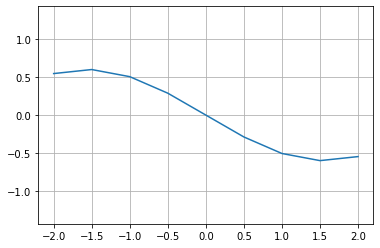

In [20]:
# write your code to simulate straight line motion 
# robot can be assumed to be moving at constant speed of 2 m/s for 30 seconds
# feel free to borrow code from your previous notebooks
plt.figure()
plt.grid()
plt.axes().set_aspect("equal","datalim")
plt.plot(np.linspace(-2, 2, num=9),final_x[:,0])
plt.show()

## Demonstrate localization drift in wheel encoders

### Synthetic dataset

In [21]:
all_v = np.ones(100)
all_w = np.zeros(100) 

In [22]:
robot_traj, robot_traj_noisy = [], []
ideal_pose = np.array([0, 0, np.pi/2])
noisy_pose = np.array([0, 0, np.pi/2])
for v, w in zip(all_v, all_w):
    robot_traj.append(ideal_pose)
    robot_traj_noisy.append(noisy_pose)
    #code to update ideal_pose
    ideal_pose = unicycle_model(ideal_pose, v,w)
    
    #code to update noisy pose
    #add gaussian noise with std dev of 0.01 to omega
    noisy_pose = unicycle_model(noisy_pose, v,w+np.random.normal(0,0.01))
    
robot_traj = np.array(robot_traj)
robot_traj_noisy = np.array(robot_traj_noisy)

No handles with labels found to put in legend.


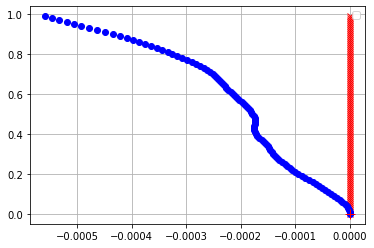

In [23]:
plt.figure()
plt.grid()
# plt.axes().set_aspect("equal","datalim")
plt.plot(robot_traj[:,0], robot_traj[:,1],'rx')
plt.plot(robot_traj_noisy[:,0], robot_traj_noisy[:,1],'bo')
plt.plot(0, 0, 'r+', ms=10)
plt.legend()

### Real dataset

In [26]:
from google.colab import files
uploaded = files.upload()

Saving wheel_control.csv to wheel_control.csv
Saving ground_truth.csv to ground_truth.csv


In [27]:
data_dir = "."
ground_truth = pd.read_csv(data_dir + "/ground_truth.csv")
gt_traj = np.array(ground_truth[['x','y']])
wheel_enc = np.array(pd.read_csv(data_dir + "/wheel_control.csv")[['v','w']])

In [28]:
pose = np.array(ground_truth[['x','y','theta']])[0] #initial pose
robot_traj = []
for v, w in wheel_enc:
    robot_traj.append(pose)
    # code for updating pose
    pose = unicycle_model(pose, v,w)
robot_traj = np.array(robot_traj)

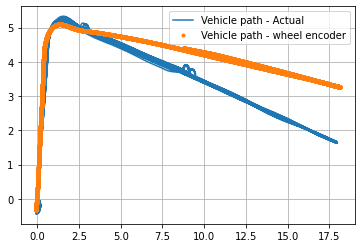

In [29]:
end = 10000
plt.figure()
plt.grid()
plt.plot(gt_traj[:,0], gt_traj[:,1], label='Vehicle path - Actual')
plt.plot(robot_traj[:end,0], robot_traj[:end,1], '.', label='Vehicle path - wheel encoder')
plt.legend()
plt.show()